In [25]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from IPython.display import HTML, Video,display
from csbdeep.utils import normalize
import numpy as np
import tifffile as tiff
import imageio.v3 as iio
from tqdm import tqdm
import re
import pandas as pd
from skimage.exposure import match_histograms

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DeepCAD-RT Training on Synthetic Dataset

ℹ️ This notebook visualizes the trainings made with [deepcad_train.py](deepcad_train.py).

Please refer to the script to run the training. The provided configuration run in about 20m on 2 A100 64GB GPUs.

## 1. Convert test video from TIFF to MP4

In [3]:
trainings = {
    "vanilla": "synthetic_202509191151",
}

In [ ]:
dir = Path("pth") / trainings["vanilla"]
prediction_dir = Path(f"results/{dir.parts[-1]}")
prediction_dir.mkdir(exist_ok=True)

for file in tqdm(sorted(dir.glob("*.tif"))):
    Recording(file).render(prediction_dir / f"{file.stem}.mp4", codec="libx264")

In [7]:
for name, t in trainings.items():
    file = sorted(Path(f"results/{t}").glob("*.mp4"))[-1]
    cprint("Showing", f"green:{name}", f"yellow:Epoch {file.stem.split('E_')[1].split('_')[0]}")
    display(Video(url=str(file)))

Showing vanilla Epoch 10


Results are completely black when changing footage from the train set.

## 2. Comparing training results with given baseline

In [ ]:
x = Recording("dataset/synthetic/x.tiff", max_frames=10).normalized
y = Recording("../dataset/zenodo/synthetic/clean_30Hz_490x490x6000.tif", max_frames=10).normalized
pred = Recording("pth/synthetic_202509191151/xf_E_10_Iter_0808.tif", max_frames=10).normalized

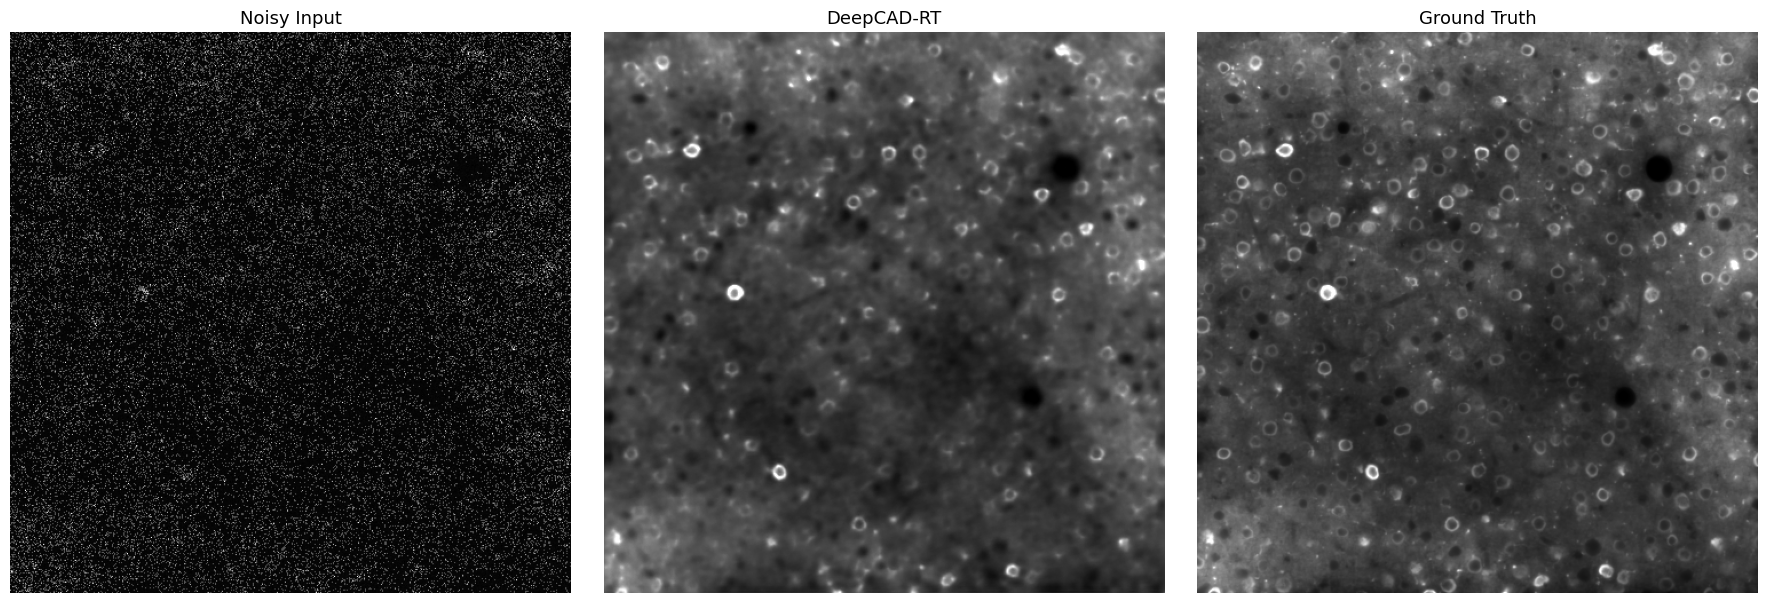

In [28]:
imshow(
    {
        "Noisy Input": x[-1],
        "DeepCAD-RT": pred[-1],
        "Ground Truth": y[-1],
    },
    size=6,
    cmap="grey",
    vrange=(0, 1),
)

## 3. Extract loss trend from logs

In [10]:
log_path = Path(f"results/{trainings['vanilla']}/log")

In [11]:
l1 = []
with open(log_path) as f:
    for line in tqdm(_ for _ in f.readlines() if "[Total loss:" in _):
        if match := re.search(r"L1 Loss: ([\d\.eE+-]+)", line):
            l1.append(float(match.group(1)))

8080it [00:00, 733708.08it/s]


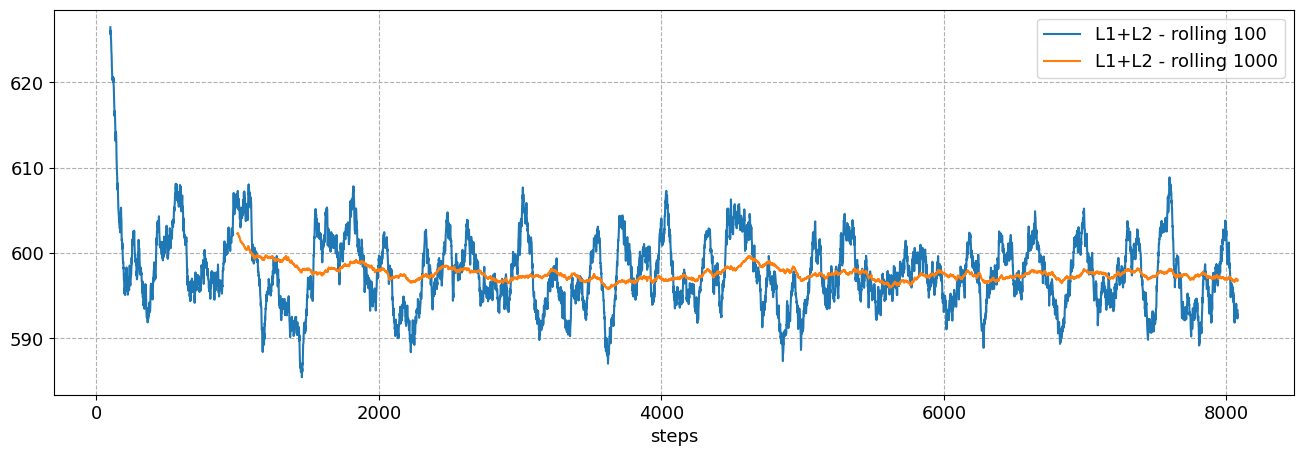

In [27]:
l1 = pd.Series(l1)
df = pd.DataFrame(
    {
        "steps": range(len(l1)),
        "L1+L2 - rolling 100": l1.rolling(100).mean(),
        "L1+L2 - rolling 1000": l1.rolling(1000).mean(),
    }
)
ax = df.plot(x="steps", figsize=(16, 5))
ax.set_xticks(range(0, len(df), 2000));

## Comparing Training vs Testing DeepCAD
Testing inference is better than training

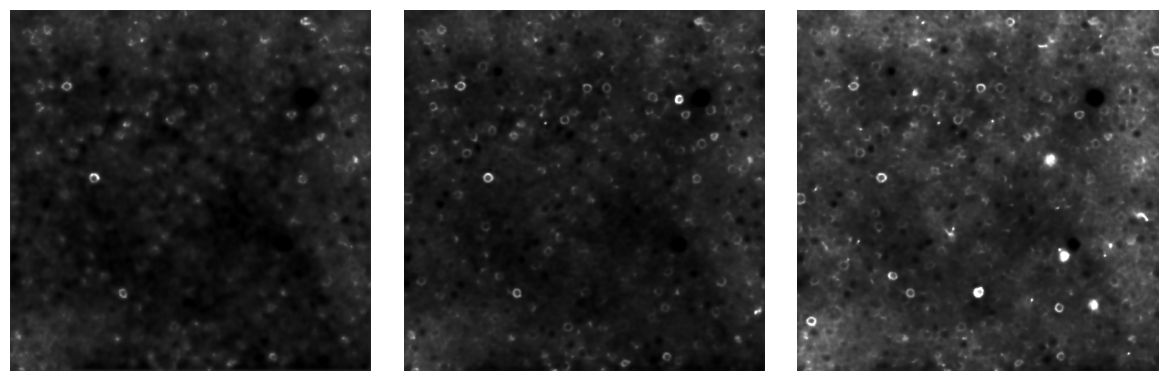

In [13]:
x = Recording(
    "results/DataFolderIs_synthetic_202509201109_ModelFolderIs_synthetic_202509191151/E_10_Iter_0808/x_E_10_Iter_0808_output.tif"
)
imshow([_ for _ in x.normalized[::100]], zoom=1, vrange=(0, 1))

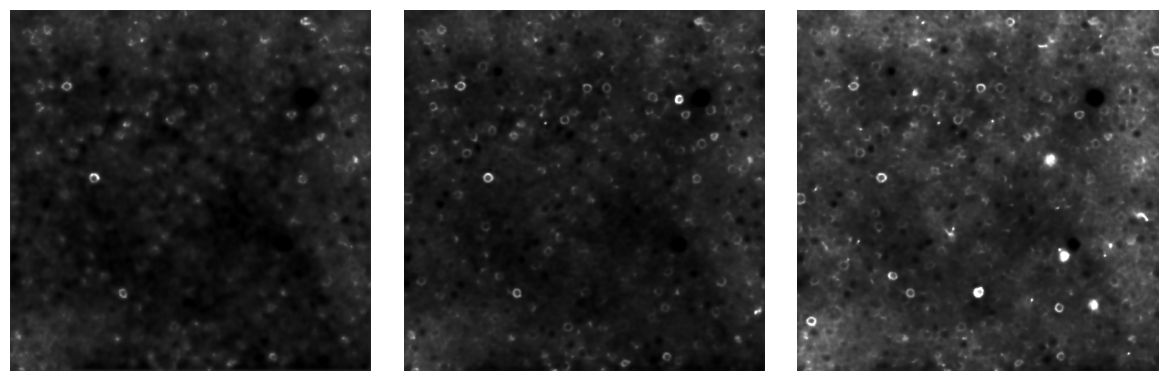

In [14]:
x_old=Recording("../dataset/zenodo/synthetic/deepcad_E_10.tif")
imshow([_ for _ in x.normalized[::100]], zoom=1, vrange=(0,1))

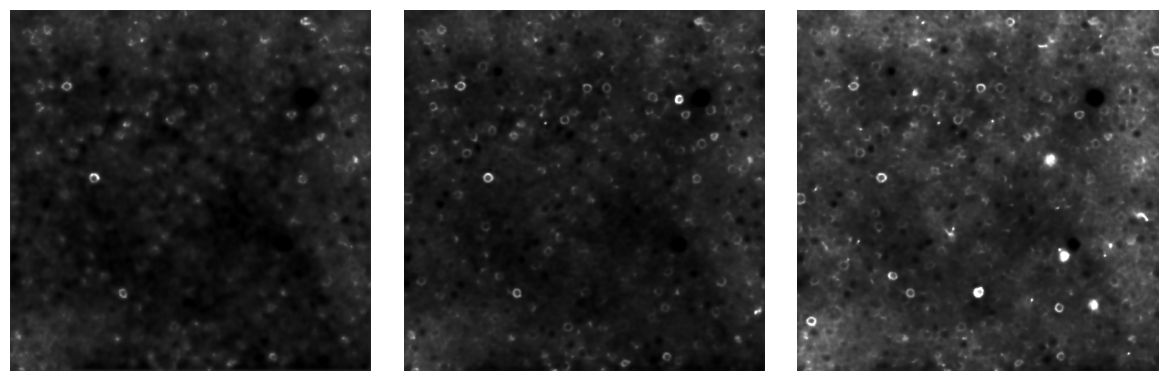

In [15]:
y=Recording("../dataset/zenodo/synthetic/clean_30Hz_490x490x6000.tif")
imshow([_ for _ in x.normalized[::100]], zoom=1, vrange=(0,1))

<Axes: >

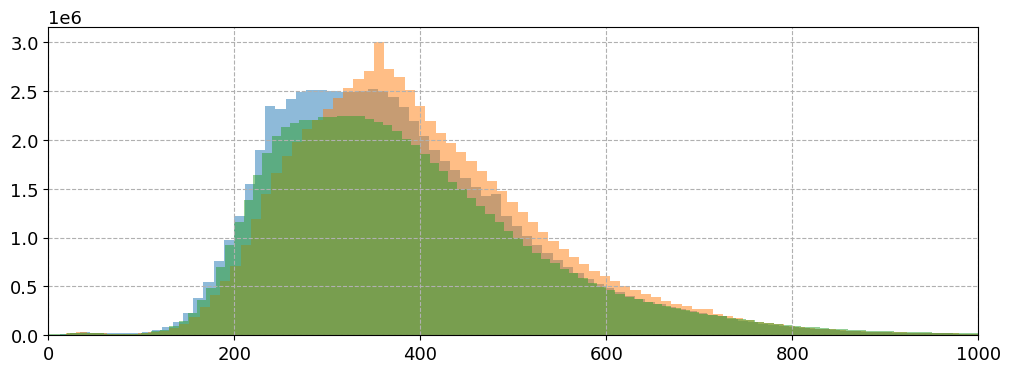

In [21]:
ax=pd.Series(x.np.ravel()).hist(bins=2000, figsize=(12,4), alpha=0.5)
ax.set_xlim(0,1000)
pd.Series(x_old.np.ravel()).hist(bins=2000, figsize=(12,4), ax=ax, alpha=0.5)
pd.Series(y.np.ravel()).hist(bins=2000, figsize=(12,4), ax=ax, alpha=0.5)

In [ ]:
# 23s
x_match = match_histograms(x.np, y.np)
x_old_match = match_histograms(x_old.np, y.np)

<Axes: >

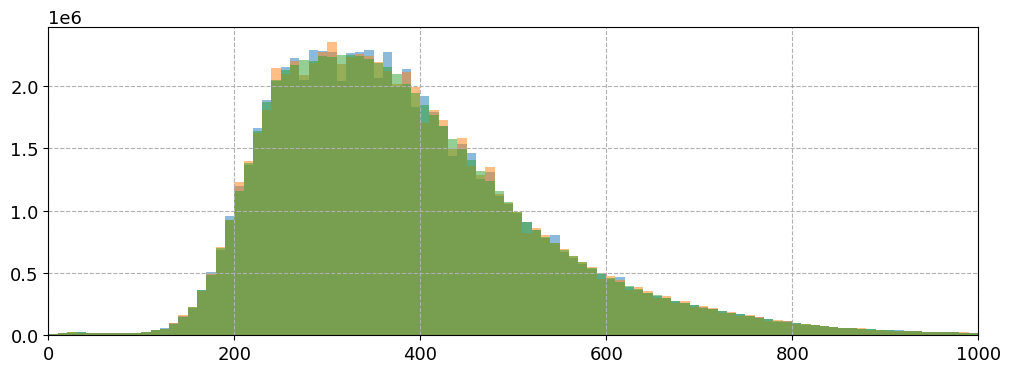

In [27]:
ax=pd.Series(x_match.ravel()).hist(bins=2000, figsize=(12,4), alpha=0.5)
ax.set_xlim(0,1000)
pd.Series(x_old_match.ravel()).hist(bins=2000, figsize=(12,4), ax=ax, alpha=0.5)
pd.Series(y.np.ravel()).hist(bins=2000, figsize=(12,4), ax=ax, alpha=0.5)

In [24]:
psnr3d(x,y, data_range=1_000), psnr3d(x_old,y,data_range=1_000)

(np.float64(28.132420479475), np.float64(16.61894010785583))

In [19]:
psnr3d(x.normalized,y.normalized), psnr3d(x_old.normalized,y.normalized)

(np.float64(33.2508616708612), np.float64(25.344238114286682))

In [28]:
psnr3d(x_match, y, data_range=1_000), psnr3d(x_old_match, y, data_range=1_000)

(np.float64(28.25425892665435), np.float64(16.70721713188596))

Testing DeepCAD footage are much better than training ones!